<a href="https://colab.research.google.com/github/Aayush-Jain01/AI_For_Economics_Term_Project/blob/main/LSTM%2BTweet_Extraction_%2B_TextBlob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from textblob import TextBlob

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
print(TextBlob("good").sentiment.polarity)

0.7


In [ ]:
print(TextBlob("bad").sentiment.polarity)

-0.6999999999999998


In [ ]:
print(TextBlob("The restaurant was not that great").sentiment.polarity)

0.8


In [ ]:
a = sentiment.polarity_scores("The restaurant was not that great") #Vader is better 
print(a)

{'neg': 0.397, 'neu': 0.603, 'pos': 0.0, 'compound': -0.5096}


In [ ]:
! pip3 install tweepy --upgrade

     |████████████████████████████████| 65 kB 2.1 MB/s 
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0


In [ ]:
import os
os.environ["BEARER_TOKEN"] = 'AAAAAAAAAAAAAAAAAAAAAF3EWgEAAAAALyiGBw2dczuo%2FFfQKmnzjbIn5co%3D4JG5uoNFwSGaj2o4o2KVuFv4MaGXWrO63H8Uwjok8vLbOh7uTY'

In [ ]:
import tweepy as tw
import pandas as pd
import datetime as dt
import time
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
client = tw.Client(bearer_token= BEARER_TOKEN)
query = '#Microsoft -is:retweet lang:en'
initial_tweets = []
for response in tw.Paginator(client.search_recent_tweets, 
                             query= query, 
                             user_fields = ['username', 'public_metrics', 'description', 'location'], 
                             tweet_fields=['created_at', 'geo', 'public_metrics', 'text'], 
                             expansions= ['author_id'], max_results= 100, limit= 1000):
  time.sleep(1)
  initial_tweets.append(response)
# tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=100)
# data=pd.DataFrame(data=[[tweet.created_at.date(), tweet.text]for tweet in tweets.data],columns=['Date','Tweets'])
# print(data)
# print(initial_tweets[0].data)
# data = pd.DataFrame(initial_tweets[0]["data"])
# data.to_csv('data.csv')

In [ ]:
result = []
user_dict = {}
for response in initial_tweets:
    # Take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
    for user in response.includes['users']:
        user_dict[user.id] = {'username': user.username, 
                              'location': user.location
                             }
    for tweet in response.data:
        # For each tweet, find the author's information
        author_info = user_dict[tweet.author_id]
        # Put all of the information we want to keep in a single dictionary for each tweet
        result.append({'search_word' : "#Microsoft",
                       'username': author_info['username'],
                       'location': author_info['location'],
                       'text': tweet.text,
                       'created_at': tweet.created_at,
                      })

# Change this list of dictionaries into a dataframe
# df = pd.DataFrame(result, columns= ["search_word", "user", "location", "text", "date"])
df = pd.DataFrame(result)

In [ ]:
df

,search_word,username,location,text,created_at
0,#Microsoft,NareshBellapu1,Hyderabad,@cloudthat Answers\n1. Azure Developer Associa...,2021-12-12 15:53:39+00:00
1,#Microsoft,v_srikanth70,"Haiderabad, India",@cloudthat 0️⃣1️⃣. Azure Developer Associate -...,2021-12-12 15:53:35+00:00
2,#Microsoft,drmiru,Switzerland,The Microsoft Azure Daily is here! https://t.c...,2021-12-12 15:53:10+00:00
3,#Microsoft,imAjayKewat,None,@cloudthat 1️⃣ Azure Developer Associate ➡️ Az...,2021-12-12 15:52:28+00:00
4,#Microsoft,365gravity,"Grand Rapids, MI",Future trends in Business Intelligence https:/...,2021-12-12 15:51:01+00:00
...,...,...,...,...,...
9970,#Microsoft,reblaze,"San Jose, California, USA",#Microsoft is continually adding to #Azure’s c...,2021-12-05 16:00:57+00:00
9971,#Microsoft,bananas1978,Cwmbran,The latest The Office 365 Daily! https://t.co/...,2021-12-05 16:00:49+00:00
9972,#Microsoft,hiroyuki_otaTw,日本 東京,#3 #3HIROYUKIOTA #gallop #mit #nato#softbank #...,2021-12-05 16:00:23+00:00
9973,#Microsoft,cloud_thing,"Longbridge, England",How can the Microsoft Dataverse benefit your o...,2021-12-05 16:00:10+00:00


In [ ]:
df.to_csv("Microsoft_Tweets.csv")

In [ ]:
import re
import nltk
from nltk import PorterStemmer
ps = PorterStemmer()
nltk.download("stopwords")
from nltk.corpus import stopwords
stop = stopwords.words('english')
def cleantweets(txt):
  # Remove mentions
  txt = re.sub(r"@","", txt)
  # Remove hashtags
  txt = re.sub(r"#","", txt)
  # Remove urls
  txt = re.sub(r"https?:\/\/[ A−Za−z0 −9\.\/]+", "", txt)
  # Remove Stop Words
  txt = ' '.join([word for word in txt.split() if word not in (stop)])
  #Stemming
  txt = ' '.join([ps.stem(word) for word in txt.split()])
  return txt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def getsubjectivity(txt):
  return TextBlob(txt).sentiment.subjectivity

In [ ]:
def getpolarity(txt):
  return TextBlob(txt).sentiment.polarity

In [ ]:
def getanalysis(a):
  if a < 0:
    return "Negative"
  elif a == 0:
    return "Neutral"
  else:
    return "Positive"

In [ ]:
def prepare_twitter_data(tweet_data):
  results = tweet_data.copy()
  results["clean text"] = results["text"].apply(cleantweets)
  results["polarity"] = results["text"].apply(getpolarity)
  results["subjectivity"] = results["text"].apply(getsubjectivity)
  results["tweet_class"] = results["polarity"].apply(getanalysis)
  return results

In [ ]:
def sorttwitterdata(tweet_data):
  results = prepare_twitter_data(tweet_data)
  results["created_at"] = pd.to_datetime(results["created_at"], format = '%Y−%m−%d %H:%M:%S')
  print("sorting")
  results = results.sort_values(by=["created_at"], ascending=[False])
  return results

In [ ]:
processed_tweets = sorttwitterdata(df)

sorting


In [ ]:
processed_tweets

,search_word,username,location,text,created_at,clean text,polarity,subjectivity,tweet_class
0,#Microsoft,NareshBellapu1,Hyderabad,@cloudthat Answers\n1. Azure Developer Associa...,2021-12-12 15:53:39+00:00,cloudthat answer 1. azur develop associ AZ - 2...,0.000000,0.000000,Neutral
1,#Microsoft,v_srikanth70,"Haiderabad, India",@cloudthat 0️⃣1️⃣. Azure Developer Associate -...,2021-12-12 15:53:35+00:00,cloudthat 0️⃣1️⃣. azur develop associ -az- 204...,0.000000,0.000000,Neutral
2,#Microsoft,drmiru,Switzerland,The Microsoft Azure Daily is here! https://t.c...,2021-12-12 15:53:10+00:00,the microsoft azur daili here! https://t.co/eo...,0.000000,0.000000,Neutral
3,#Microsoft,imAjayKewat,None,@cloudthat 1️⃣ Azure Developer Associate ➡️ Az...,2021-12-12 15:52:28+00:00,cloudthat 1️⃣ azur develop associ ➡️ az-204 2️...,0.000000,0.000000,Neutral
4,#Microsoft,365gravity,"Grand Rapids, MI",Future trends in Business Intelligence https:/...,2021-12-12 15:51:01+00:00,futur trend busi intellig https://t.co/pc0kz7r...,0.000000,0.125000,Neutral
...,...,...,...,...,...,...,...,...,...
9970,#Microsoft,reblaze,"San Jose, California, USA",#Microsoft is continually adding to #Azure’s c...,2021-12-05 16:00:57+00:00,microsoft continu ad azure’ capabl recent upda...,0.259091,0.470909,Positive
9971,#Microsoft,bananas1978,Cwmbran,The latest The Office 365 Daily! https://t.co/...,2021-12-05 16:00:49+00:00,the latest the offic 365 daily! https://t.co/d...,0.250000,0.450000,Positive
9972,#Microsoft,hiroyuki_otaTw,日本 東京,#3 #3HIROYUKIOTA #gallop #mit #nato#softbank #...,2021-12-05 16:00:23+00:00,3 3hiroyukiota gallop mit natosoftbank ntt app...,-0.062500,0.375000,Negative
9973,#Microsoft,cloud_thing,"Longbridge, England",How can the Microsoft Dataverse benefit your o...,2021-12-05 16:00:10+00:00,how microsoft datavers benefit organisation? b...,0.000000,0.000000,Neutral


In [ ]:
stock_df = pd.read_csv("MSFT.csv")
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-12-13,27.250000,27.450001,27.172501,27.245001,21.481600,47943855
1,2010-12-14,27.320000,27.750000,27.260000,27.620001,21.777269,64095005
2,2010-12-15,27.540001,27.990000,27.530001,27.850000,21.958616,69634200
3,2010-12-16,27.760000,27.990000,27.660000,27.987499,22.067030,57680104
4,2010-12-17,27.889999,28.090000,27.750000,27.902500,22.000013,87456444
...,...,...,...,...,...,...,...
2764,2021-12-06,323.950012,327.450012,319.230011,326.190002,326.190002,30032556
2765,2021-12-07,331.640015,335.799988,330.100006,334.920013,334.920013,31021936
2766,2021-12-08,335.309998,335.500000,330.799988,334.970001,334.970001,24760988
2767,2021-12-09,334.410004,336.489014,332.119995,333.100006,333.100006,21561374


In [ ]:
import pandas as pd

df = pd.read_csv("MSFT.csv")
#converting to pandas date for indexing
df['Date'] =  pd.to_datetime(df['Date'], format='%Y/%m/%d')
#sorting according to date
df = df.sort_values(by=['Date'], ascending=[True])

# #indexing according to date
df.set_index('Date', inplace=True)

#populating data according to previous value
df = df.resample('D').ffill().reset_index()

#exporting to MSFT_complete
df.to_csv("MSFT_complete.csv")

In [ ]:
stock_df_processed = pd.read_csv("MSFT_complete.csv", parse_dates = True, index_col = 'Date')
stock_df_processed

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2010-12-13,0,27.250000,27.450001,27.172501,27.245001,21.481600,47943855
2010-12-14,1,27.320000,27.750000,27.260000,27.620001,21.777269,64095005
2010-12-15,2,27.540001,27.990000,27.530001,27.850000,21.958616,69634200
2010-12-16,3,27.760000,27.990000,27.660000,27.987499,22.067030,57680104
2010-12-17,4,27.889999,28.090000,27.750000,27.902500,22.000013,87456444
...,...,...,...,...,...,...,...
2021-12-06,4011,323.950012,327.450012,319.230011,326.190002,326.190002,30032556
2021-12-07,4012,331.640015,335.799988,330.100006,334.920013,334.920013,31021936
2021-12-08,4013,335.309998,335.500000,330.799988,334.970001,334.970001,24760988


In [ ]:
del stock_df_processed["Unnamed: 0"]

In [ ]:
stock_df_processed

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-13,27.250000,27.450001,27.172501,27.245001,21.481600,47943855
2010-12-14,27.320000,27.750000,27.260000,27.620001,21.777269,64095005
2010-12-15,27.540001,27.990000,27.530001,27.850000,21.958616,69634200
2010-12-16,27.760000,27.990000,27.660000,27.987499,22.067030,57680104
2010-12-17,27.889999,28.090000,27.750000,27.902500,22.000013,87456444
...,...,...,...,...,...,...
2021-12-06,323.950012,327.450012,319.230011,326.190002,326.190002,30032556
2021-12-07,331.640015,335.799988,330.100006,334.920013,334.920013,31021936
2021-12-08,335.309998,335.500000,330.799988,334.970001,334.970001,24760988


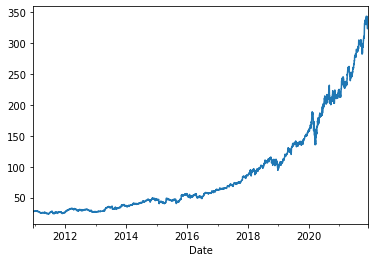

In [ ]:
stock_df_processed['Close'].plot()

In [ ]:
stock_df_processed.corr()['Close']

Open         0.999813
High         0.999900
Low          0.999898
Close        1.000000
Adj Close    0.999986
Volume      -0.284249
Name: Close, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [ ]:
stock_df_processed.drop(columns=['Volume','Adj Close'],inplace=True)

In [ ]:
stock_df_processed

,Open,High,Low,Close
Date,,,,
2010-12-13,27.250000,27.450001,27.172501,27.245001
2010-12-14,27.320000,27.750000,27.260000,27.620001
2010-12-15,27.540001,27.990000,27.530001,27.850000
2010-12-16,27.760000,27.990000,27.660000,27.987499
2010-12-17,27.889999,28.090000,27.750000,27.902500
...,...,...,...,...
2021-12-06,323.950012,327.450012,319.230011,326.190002
2021-12-07,331.640015,335.799988,330.100006,334.920013
2021-12-08,335.309998,335.500000,330.799988,334.970001


In [ ]:
#Merge Stock And Twitter Sentiment
processed_tweets = processed_tweets.loc[:, processed_tweets.columns.intersection(['created_at','polarity'])]
processed_tweets = processed_tweets.set_index('created_at').groupby(pd.Grouper(freq='d')).mean().dropna(how='all')
processed_tweets = processed_tweets.resample('D').ffill().reset_index()

In [ ]:
processed_tweets

,created_at,polarity
0,2021-12-05 00:00:00+00:00,0.082534
1,2021-12-06 00:00:00+00:00,0.124675
2,2021-12-07 00:00:00+00:00,0.091648
3,2021-12-08 00:00:00+00:00,0.117252
4,2021-12-09 00:00:00+00:00,0.115124
5,2021-12-10 00:00:00+00:00,0.141031
6,2021-12-11 00:00:00+00:00,0.132675
7,2021-12-12 00:00:00+00:00,0.117387


In [ ]:
import pandas as pd
MSFT_Final_df = pd.read_csv("MSFT_with_textblob_sentiment.csv", parse_dates = True, index_col = 'Date')
MSFT_Final_df

,Unnamed: 0,Unnamed: 0.1,Open,High,Low,Close,Adj Close,Volume,textblob_sentiment
Date,,,,,,,,,
2009-09-21,0,0,25.110001,25.370001,25.100000,25.299999,19.717058,28878700,0.062500
2009-09-22,1,1,25.400000,25.820000,25.290001,25.770000,20.083347,61376700,-0.092857
2009-09-23,2,2,25.920000,26.250000,25.639999,25.709999,20.036585,60599900,-0.092857
2009-09-24,3,3,25.920000,26.110001,25.660000,25.940001,20.215834,56302900,0.039545
2009-09-25,4,4,25.690001,25.820000,25.520000,25.549999,19.911896,50158900,0.078788
...,...,...,...,...,...,...,...,...,...
2020-05-24,3898,3898,183.190002,184.460007,182.539993,183.509995,183.509995,20826900,-0.024881
2020-05-25,3899,3899,183.190002,184.460007,182.539993,183.509995,183.509995,20826900,-0.024881
2020-05-26,3900,3900,186.339996,186.500000,181.100006,181.570007,181.570007,36073600,0.150000


In [ ]:
del MSFT_Final_df['Unnamed: 0']
del MSFT_Final_df['Unnamed: 0.1']

In [ ]:
MSFT_Final_df.drop(columns=['Volume','Adj Close'],inplace=True)

In [ ]:
MSFT_Final_df

,Open,High,Low,Close,textblob_sentiment
Date,,,,,
2009-09-21,25.110001,25.370001,25.100000,25.299999,0.062500
2009-09-22,25.400000,25.820000,25.290001,25.770000,-0.092857
2009-09-23,25.920000,26.250000,25.639999,25.709999,-0.092857
2009-09-24,25.920000,26.110001,25.660000,25.940001,0.039545
2009-09-25,25.690001,25.820000,25.520000,25.549999,0.078788
...,...,...,...,...,...
2020-05-24,183.190002,184.460007,182.539993,183.509995,-0.024881
2020-05-25,183.190002,184.460007,182.539993,183.509995,-0.024881
2020-05-26,186.339996,186.500000,181.100006,181.570007,0.150000


In [ ]:
MSFT_Final_df.columns = [['open', 'high', 'low','close','sentiment']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [ ]:
data = sc.fit_transform(MSFT_Final_df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
data

array([[0.01205539, 0.01224759, 0.01447417, 0.01382099, 0.53125   ],
       [0.01378611, 0.01493607, 0.01563455, 0.01665761, 0.45357143],
       [0.01688947, 0.01750508, 0.01777207, 0.01629549, 0.45357143],
       ...,
       [0.97427788, 0.97490741, 0.96720413, 0.95696789, 0.575     ],
       [0.9376343 , 0.94796277, 0.93972154, 0.95841632, 0.66704545],
       [0.94085707, 0.96086747, 0.96280691, 0.9559418 , 0.5625    ]])

In [ ]:
train_ind = int(0.6*len(MSFT_Final_df))
val_ind = train_ind + int(0.2*len(MSFT_Final_df))
train = data[:train_ind]
val = data[train_ind:val_ind]
test = data[val_ind:]

In [ ]:
xtrain,ytrain,xval,yval,xtest,ytest = train[:,:],train[:,3],val[:,:],val[:,3],test[:,:],test[:,3]
xtrain.shape, ytrain.shape

((2341, 5), (2341,))

In [ ]:
lookback = 60 #Past 60 days data
n_features = 5
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

In [ ]:
import numpy as np
x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (2281, 60, 5)
y_train (2281,)


In [ ]:
x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)

x_val (720, 60, 5)
y_val (720,)


In [ ]:
x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_test (722, 60, 5)
y_test (722,)


In [ ]:
import tensorflow
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential() 
model.add(LSTM(110,input_shape = (lookback, n_features), return_sequences=True)) # Stacking the LSTM so return_sequences = True for next LSTM
model.add(LSTM(110))
model.add(Dense(1))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam', metrics= ['mape'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

In [ ]:
start = time()
print("start:",0)
model.fit(x_train,y_train, epochs = 60, batch_size=40, 
          validation_data=(x_val,y_val),verbose = 1, 
          shuffle = False)
print("end:",time()-start)

start: 0
Epoch 1/60
58/58 [==============================] - 10s 54ms/step - loss: 0.0012 - mape: 12568.5693 - val_loss: 0.0034 - val_mape: 14.0109
Epoch 2/60
58/58 [==============================] - 2s 37ms/step - loss: 0.0015 - mape: 23853.2422 - val_loss: 0.0101 - val_mape: 25.3127
Epoch 3/60
58/58 [==============================] - 2s 39ms/step - loss: 0.0017 - mape: 41787.7656 - val_loss: 0.0114 - val_mape: 29.5659
Epoch 4/60
58/58 [==============================] - 2s 37ms/step - loss: 0.0011 - mape: 35273.8516 - val_loss: 0.0061 - val_mape: 21.3169
Epoch 5/60
58/58 [==============================] - 2s 39ms/step - loss: 7.5562e-04 - mape: 32546.5996 - val_loss: 0.0030 - val_mape: 14.1253
Epoch 6/60
58/58 [==============================] - 2s 40ms/step - loss: 6.1330e-04 - mape: 28667.0547 - val_loss: 7.2534e-04 - val_mape: 6.7363
Epoch 7/60
58/58 [==============================] - 2s 37ms/step - loss: 4.8006e-04 - mape: 23851.5059 - val_loss: 3.3432e-04 - val_mape: 4.7836
Epoch 

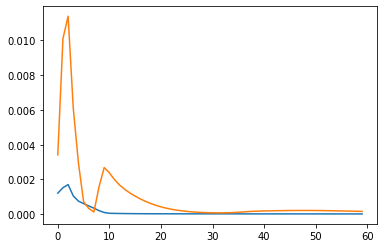

In [ ]:
import matplotlib.pyplot as plt
loss = model.history.history
loss = pd.DataFrame(loss)
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])

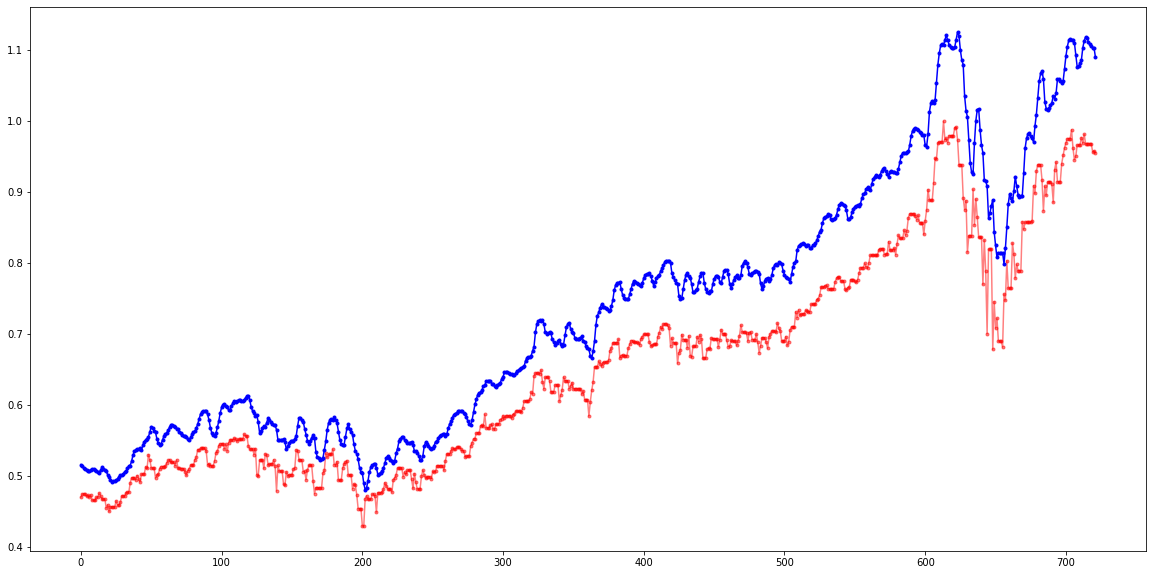

In [ ]:
y_pred = model.predict(x_test)

plt.figure(figsize=(20,10))
plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)

In [ ]:
model.evaluate(x_test, y_test)

23/23 [==============================] - 1s 13ms/step - loss: 0.0069 - mape: 11.1401


[0.006857177242636681, 11.140066146850586]